<a href="https://colab.research.google.com/github/nikhil-1e9/AV-Hackathon/blob/main/AV_match_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AUS vs IND (CWC 2023) match predictions
![](https://assets-in.bmscdn.com/nmcms/events/banner/desktop/media-desktop-india-vs-australia-icc-mens-cwc-2023-0-2023-8-24-t-5-48-10.jpg)

## Problem Statement
The task is to make precise predictions regarding the runs scored and wickets taken by each player who has been carefully selected to represent their respective teams, India and Australia 15 members squad in the highly anticipated ICC World Cup 2023 clash on Oct 8, 2023. Make use of data science models and techniques based upon extensive historical data encompassing both player and team performance,to make well-informed predictions.

## About Data
The dataset contains the batting and bowling statistics of the 30 players selected for the ICC World Cup 2023 of both teams India and Australia. The dataset contains the batting and bowling stats of each ODI played by the cricketer throughout his career. We are free to choose any external dataset but I researched a lot and found the given dataset the most helpful.

## Load data

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
# Load data into csv files
train = pd.read_csv("C:/Users/relat/Downloads/data_zpyYWs0.csv")
sub = pd.read_csv("C:/Users/relat/Downloads/sample_submission_Gk1Mne1.csv")

In [ ]:
train

,player_id,player_name,runs_scored,wickets,runs_conceded,catches,stumpings,match_date,opposition,match_id
0,1,Pat Cummins,DNB,3,28,0,0,19 Oct 2011,v South Africa Centurion,1
1,2,Steve Smith,DNB,-,-,0,0,19 Oct 2011,v South Africa Centurion,1
2,10,Mitch Marsh,8*,1,19,1,0,19 Oct 2011,v South Africa Centurion,1
3,13,David Warner,20,-,-,0,0,19 Oct 2011,v South Africa Centurion,1
4,1,Pat Cummins,11*,1,73,0,0,23 Oct 2011,v South Africa Gqeberha,2
...,...,...,...,...,...,...,...,...,...,...
2570,22,Ravindra Jadeja,DNB,3,35,0,0,28 Oct 2009,v Australia Nagpur,553
2571,22,Ravindra Jadeja,DNB,2,41,0,0,31 Oct 2009,v Australia Delhi,554
2572,22,Ravindra Jadeja,23,0,44,1,0,5 Nov 2009,v Australia Hyderabad,555
2573,22,Ravindra Jadeja,57,0,36,0,0,8 Nov 2009,v Australia Guwahati,556


In [ ]:
# Check data statictics
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2575 entries, 0 to 2574
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   player_id      2575 non-null   int64 
 1   player_name    2575 non-null   object
 2   runs_scored    2575 non-null   object
 3   wickets        2575 non-null   object
 4   runs_conceded  2575 non-null   object
 5   catches        2575 non-null   object
 6   stumpings      2575 non-null   object
 7   match_date     2575 non-null   object
 8   opposition     2575 non-null   object
 9   match_id       2575 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 201.3+ KB


The data contains 2575 non-values and no null values for each column. Some of the columns need to be preprocessed before making predicitons. I will only need the **player_id, player_name, runs_scored, wickets, match_date, opposition and ground** columns.

## Preprocessing

In [ ]:
# clean runs scored and convert to int
train['runs_scored'] = train['runs_scored'].str.replace('*', '', regex=False)
train['runs_scored'].replace({'DNB': '-1', 'TDNB': '-1'}, inplace=True)
train['runs_scored'] = train['runs_scored'].astype('int')

# clean wickets and convert to int
train['wickets'] = train['wickets'].str.replace('-', '0', regex=False).astype('int')

# convert date to datetime
train['match_date'] = pd.to_datetime(train['match_date'])

# extract different ground names
train['ground'] = train['opposition'].apply(lambda x: x.split()[-1])

# extract opponent team
train['opposition'] = train['opposition'].apply(lambda x: x.split()[1])
train['opposition'].replace({'South': 'South Africa',
                             'New': 'New Zealand',
                             'West': 'West Indies',
                             'Sri': 'Sri Lanka',
                             'Hong': 'Hong Kong'}, inplace=True)

In the preprocessing step I:
- Cleaned and converted the runs_scored and wickets columns to int type
- Converted match_date column to datetime format.
- Separated the ground at which the match was played from the opposition column and cleaned it.

### Players
Let's visualize which id corresponds to which player and how many unique datapoints each player has

In [ ]:
id_name = train.groupby(['player_id']).player_name.first().reset_index()
id_name

,player_id,player_name
0,1,Pat Cummins
1,2,Steve Smith
2,3,Alex Carey
3,4,Josh Inglis
4,5,Sean Abbott
5,6,Marnus Labuschagne
6,7,Cameron Green
7,8,Josh Hazlewood
8,9,Travis Head
9,10,Mitch Marsh


In [ ]:
train.groupby(['player_id', 'player_name']).player_id.count()

player_id  player_name        
1          Pat Cummins             77
2          Steve Smith            145
3          Alex Carey              71
4          Josh Inglis              8
5          Sean Abbott             17
6          Marnus Labuschagne      38
7          Cameron Green           20
8          Josh Hazlewood          74
9          Travis Head             58
10         Mitch Marsh             79
11         Glenn Maxwell          129
12         Marcus Stoinis          64
13         David Warner           150
14         Adam Zampa              85
15         Mitchell Starc.        111
16         Rohit Sharma           251
17         Hardik Pandya           82
18         Shubman Gill            35
19         Virat Kohli            281
20         Shreyas Iyer            47
21         KL Rahul                61
22         Ravindra Jadeja        186
23         Shardul Thakur          44
24         Jasprit Bumrah          78
25         Mohammed Siraj          30
26         Kuldeep 

Most of the players have played less than 100 matches. This means most of these players are new

## Exploratory Data Analysis

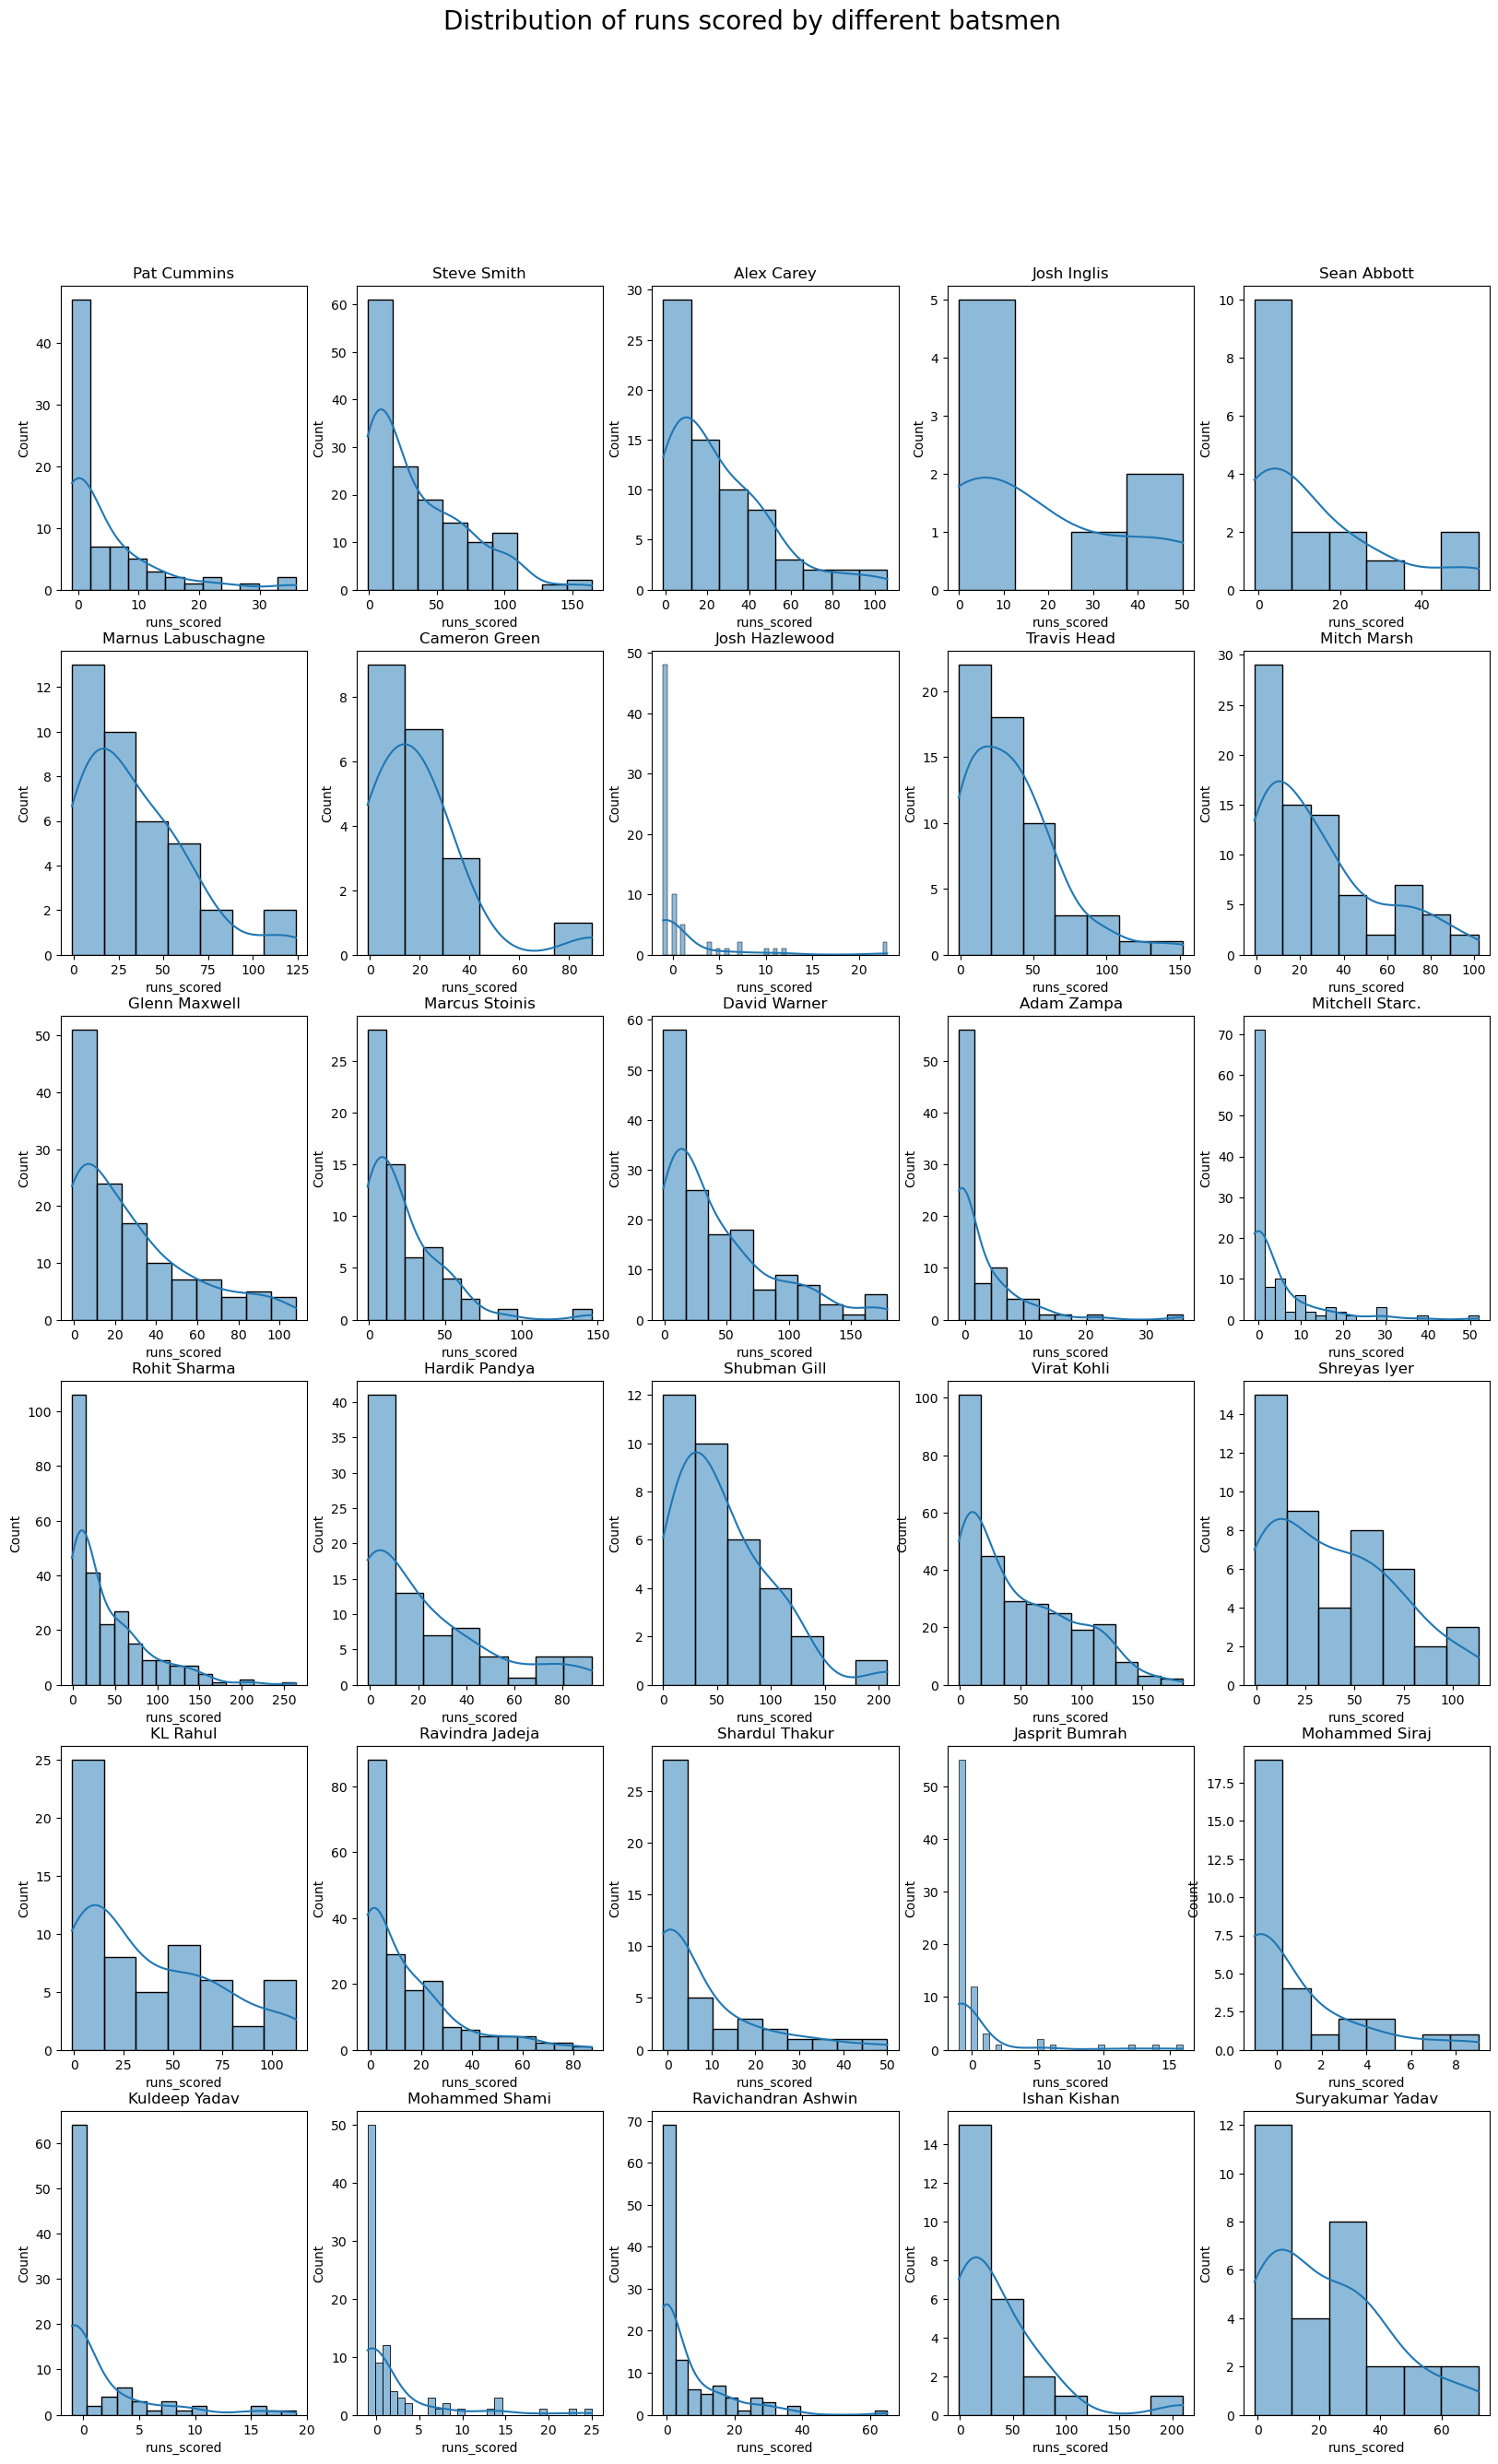

In [ ]:
# Visualizing runs scored by each individual batsman
fig, ax = plt.subplots(6,5, figsize=(20,30))
ax=ax.flatten()

for i in range(1,31):
    sns.histplot(data=train[train.player_id==i].sort_values('match_date'), x='runs_scored', kde=True, ax=ax[i-1])
    ax[i-1].set_title(*train[train.player_id==i].player_name.unique())
plt.suptitle("Distribution of runs scored by different batsmen", fontsize=20)
plt.show()

The above data is highly skewed to the right which makes sense because players can't score high runs for a large number of matches.

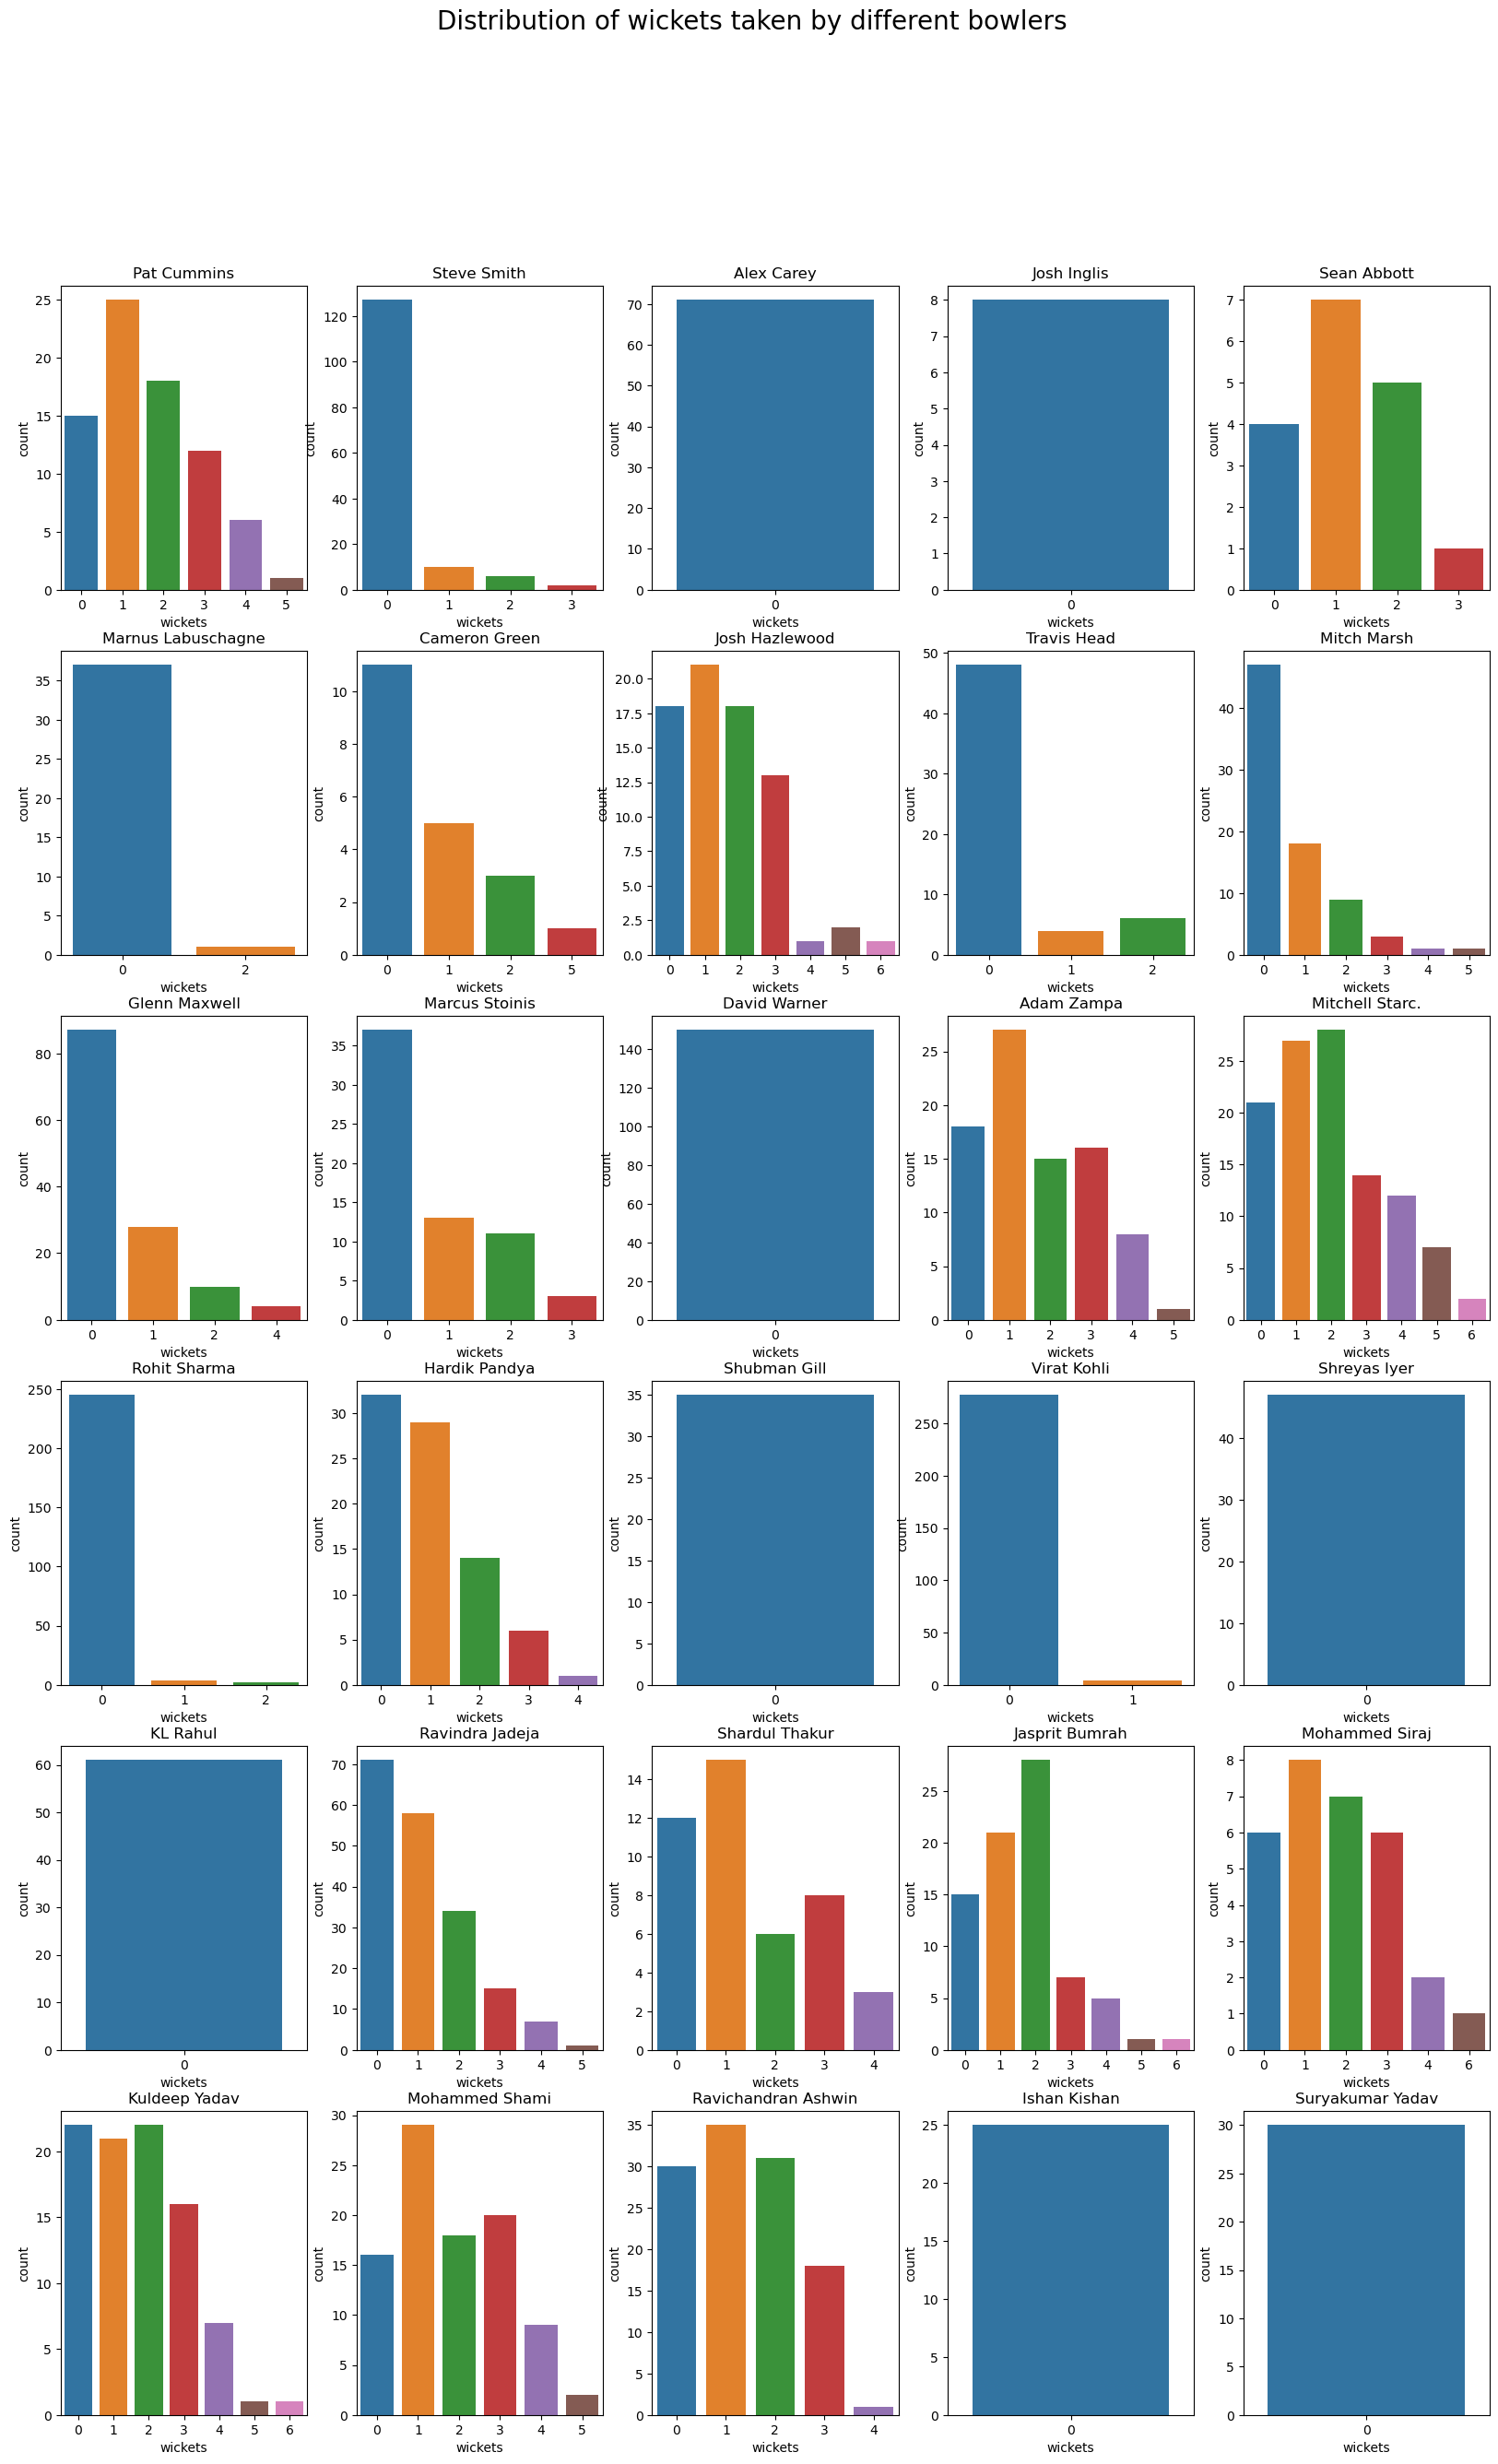

In [ ]:
# Visualizing wickets taken by each individual bowler
fig, ax = plt.subplots(6,5, figsize=(20,30))
ax=ax.flatten()

for i in range(1,31):
    sns.countplot(data=train[train.player_id==i].sort_values('match_date'), x='wickets', ax=ax[i-1])
    ax[i-1].set_title(*train[train.player_id==i].player_name.unique())
plt.suptitle("Distribution of wickets taken by different bowlers", fontsize=20)
plt.show()

Most batsman doesn't have any wickets which is quite intuitive but the surprising part is Virat Kohli, Rohit Sharma and Steve Smith also have taken some wickets at some point in their careers.

## Modeling

### Model 1: Average or Median of last N performances
In this model I just extracted the average or median runs scored or wickets taken by players in the last N number of matches they have played. This is a very simple implementation and is quite effective in making good predictions.

In [ ]:
# Make predictions based on the average of performance in last n matches
def make_predictions(df, n=5, measure='mean'):
    runs = []
    wickets = []
    for i in range(1,31):
        if measure == 'mean':
            runs.append(df[(df.player_id==i)&(df.runs_scored!=-1)].sort_values('match_date', ascending=False).runs_scored[:n].mean())
            wickets.append(df[df.player_id==i].sort_values('match_date', ascending=False).wickets[:n].mean())
        elif measure == 'median':
            runs.append(df[(df.player_id==i)&(df.runs_scored!=-1)].sort_values('match_date', ascending=False).runs_scored[:n].median())
            wickets.append(df[df.player_id==i].sort_values('match_date', ascending=False).wickets[:n].median())

    sub_df = sub.copy()
    sub_df['runs'] = runs
    sub_df['wickets'] = wickets
    sub_df['name'] = id_name['player_name']
    sub_df = sub_df[['player_id', 'name', 'runs', 'wickets']]
    return sub_df

In [ ]:
# Store predictions in sub file
sub1 = make_predictions(train, n=10, measure='median')
sub1

,player_id,name,runs,wickets
0,1,Pat Cummins,10.0,2.0
1,2,Steve Smith,51.0,0.0
2,3,Alex Carey,11.5,0.0
3,4,Josh Inglis,8.0,0.0
4,5,Sean Abbott,8.0,1.0
5,6,Marnus Labuschagne,33.5,0.0
6,7,Cameron Green,18.5,0.5
7,8,Josh Hazlewood,5.5,1.5
8,9,Travis Head,35.5,0.0
9,10,Mitch Marsh,38.0,0.0


As there are more chances of the score going between 250-300 runs for each side. I do sanity check for the same

In [ ]:
def sanity_check(df):
    # Making sure the sum of scores of best 11 batsmen for AUS is around 250-300 range and wickets should not exceed 10
    print("Total score for AUS by top 11 batsman:", df[:15].sort_values('runs', ascending=False)[:11].runs.sum())
    print("Total wickets taken by AUS top 11 bowlers:", df[:15].sort_values('wickets', ascending=False)[:11].wickets.sum())
    # Making sure the sum of scores of best 11 batsmen for IND is around 250-300 range and wickets should not exceed 10
    print("Total score for IND by top 11 batsman:", df[15:].sort_values('runs', ascending=False)[:11].runs.sum())
    print("Total wickets taken by IND top 11 bowlers:", df[15:].sort_values('wickets', ascending=False)[:11].wickets.sum())
sanity_check(sub1)

Total score for AUS by top 11 batsman: 286.0
Total wickets taken by AUS top 11 bowlers: 9.0
Total score for IND by top 11 batsman: 289.0
Total wickets taken by IND top 11 bowlers: 9.5


In [ ]:
# sub1.drop('name', axis=1, inplace=True)
# sub1.to_csv("match_preds1.csv")

### Model 2:
Analyzing head to head matches of both teams

In [ ]:
train[(train.opposition=='India')|(train.opposition=='Australia')].player_id.nunique()

30

All 30 players have played at least once in this clash.

In [ ]:
against_df = train[(train.opposition=='India')|(train.opposition=='Australia')]
print("Shape:", against_df.shape)
against_df.head()

Shape: (502, 11)


,player_id,player_name,runs_scored,wickets,runs_conceded,catches,stumpings,match_date,opposition,match_id,ground
31,1,Pat Cummins,-1,0,52,0,0,2015-01-18,India,9,Melbourne
32,2,Steve Smith,47,0,-,0,0,2015-01-18,India,9,Melbourne
33,11,Glenn Maxwell,20,0,14,2,0,2015-01-18,India,9,Melbourne
34,13,David Warner,24,0,-,0,0,2015-01-18,India,9,Melbourne
35,15,Mitchell Starc.,-1,6,43,0,0,2015-01-18,India,9,Melbourne


Let's feed it into model 1

In [ ]:
# Store predictions in sub file
sub2 = make_predictions(against_df, n=100, measure='median')
sub2

,player_id,name,runs,wickets
0,1,Pat Cummins,1.5,1.0
1,2,Steve Smith,47.0,0.0
2,3,Alex Carey,21.0,0.0
3,4,Josh Inglis,26.0,0.0
4,5,Sean Abbott,4.0,1.0
5,6,Marnus Labuschagne,33.5,0.0
6,7,Cameron Green,19.0,0.0
7,8,Josh Hazlewood,7.0,1.0
8,9,Travis Head,31.0,0.0
9,10,Mitch Marsh,47.0,0.0


In [ ]:
sanity_check(sub2)

Total score for AUS by top 11 batsman: 332.0
Total wickets taken by AUS top 11 bowlers: 5.0
Total score for IND by top 11 batsman: 258.0
Total wickets taken by IND top 11 bowlers: 7.0


In [ ]:
# sub2.drop('name', axis=1, inplace=True)
# sub2.to_csv("match_preds2.csv", index=False)

### Model 3: Weighted average by date

This model assigns a weight to every individual match_date of each player, with higher weight given to recent matches and lower weight given to older matches. This model tries to capture the form of the player as the runs he scored 5 or 10 years ago don't matter much and the his recent performance depicts his form and he is more likely to perform likewise. This can lead to better predictions but nothing can be said for certain.

In [ ]:
weights_df = train[train.player_id==1].sort_values('match_date')
weights_df['weight'] = [i/len(weights_df) for i in range(1,len(weights_df)+1)]
weights_df

,player_id,player_name,runs_scored,wickets,runs_conceded,catches,stumpings,match_date,opposition,match_id,ground,weight
0,1,Pat Cummins,-1,3,28,0,0,2011-10-19,South Africa,1,Centurion,0.012987
4,1,Pat Cummins,11,1,73,0,0,2011-10-23,South Africa,2,Gqeberha,0.025974
7,1,Pat Cummins,6,1,49,0,0,2011-10-28,South Africa,3,Durban,0.038961
9,1,Pat Cummins,-1,1,11,0,0,2012-06-23,Ireland,4,Belfast,0.051948
12,1,Pat Cummins,4,1,53,0,0,2012-06-29,England,5,Lord's,0.064935
...,...,...,...,...,...,...,...,...,...,...,...,...
582,1,Pat Cummins,-1,2,22,1,0,2022-06-24,Sri Lanka,73,(RPS),0.948052
591,1,Pat Cummins,-1,3,62,0,0,2022-11-17,England,74,Adelaide,0.961039
601,1,Pat Cummins,-1,2,25,1,0,2022-11-22,England,75,Melbourne,0.974026
612,1,Pat Cummins,21,1,44,0,0,2023-09-22,India,76,Mohali,0.987013


In [ ]:
def weighted_mean_runs(df):
    return np.sum(df.runs_scored*df.weight)/np.sum(df.weight)
def weighted_mean_wickets(df):
    return np.sum(df.wickets*df.weight)/np.sum(df.weight)

In [ ]:
def make_wtd_predictions(df):
    runs = []
    wickets = []
    for i in range(1,31):
        weights_df = df[df.player_id==i].sort_values('match_date')
        weights_df['weight'] = [j/len(weights_df) for j in range(1,len(weights_df)+1)]

        weighted_runs = weighted_mean_runs(weights_df[(weights_df.player_id==i)&(weights_df.runs_scored!=-1)])
        runs.append(weighted_runs)

        weighted_wickets = weighted_mean_wickets(weights_df[weights_df.player_id==i])
        wickets.append(weighted_wickets)

    sub_df = sub.copy()
    sub_df['runs'] = runs
    sub_df['wickets'] = wickets
    sub_df['name'] = id_name['player_name']
    sub_df = sub_df[['player_id', 'name', 'runs', 'wickets']]
    return sub_df

In [ ]:
sub3 = make_wtd_predictions(train)
sub3

,player_id,name,runs,wickets
0,1,Pat Cummins,8.047170,1.607060
1,2,Steve Smith,42.301579,0.051488
2,3,Alex Carey,27.164066,0.000000
3,4,Josh Inglis,20.000000,0.000000
4,5,Sean Abbott,17.656250,1.241830
5,6,Marnus Labuschagne,35.827004,0.045884
6,7,Cameron Green,20.910112,0.904762
7,8,Josh Hazlewood,5.553525,1.541982
8,9,Travis Head,40.410984,0.219755
9,10,Mitch Marsh,30.564077,0.579114


In [ ]:
sanity_check(sub3)

Total score for AUS by top 11 batsman: 330.1287559651316
Total wickets taken by AUS top 11 bowlers: 11.073605156231114
Total score for IND by top 11 batsman: 374.2490567534829
Total wickets taken by IND top 11 bowlers: 11.78374334781467


In [ ]:
# sub3.drop('name', axis=1, inplace=True)
# sub3.to_csv("match_preds_wtd.csv", index=False)

### Model 4: Prophet
Prophet deals with time-series data quite effectively by automatically predicting patterns, seasonality etc. in data. This approach is very robust for time-series applications but I highly doubt this approach because the data we have is way smaller than Prophet to work effectively. Nonetheless I will give it a shot.

In [ ]:
# !pip install prophet
from prophet import Prophet

In [ ]:
def fit_prophet(prophet_df, periods=15):
    # Fit the model to the data
    model = Prophet()
    model.fit(prophet_df)
    # Make future predictions
    future_dates = model.make_future_dataframe(periods=periods, freq='D', include_history=False)
    forecast = model.predict(future_dates)
    return max(0, forecast[['ds', 'yhat']].yhat.mean())

In [ ]:
def prophet_predictions(df, days=20):
    runs = []
    wickets = []
    for i in range(1,31):
        df = train[train.player_id==i]
        # Forecast ahead for 1/7th of the total number of days
#         days = len(df)//7

        # Change column names to ds and y
        prophet_df_runs = df[['match_date', 'runs_scored']].rename(columns={'match_date': 'ds', 'runs_scored': 'y'})
        prophet_df_runs = prophet_df_runs[prophet_df_runs.y!=-1]
        # Make predictions with prophet
        avg_runs = fit_prophet(prophet_df_runs, periods=days)
        runs.append(avg_runs)

        # Change column names to ds and y
        prophet_df_wicks = df[['match_date', 'wickets']].rename(columns={'match_date': 'ds', 'wickets': 'y'})
        # Make predictions with prophet
        avg_wickets = fit_prophet(prophet_df_wicks, periods=days)
        wickets.append(avg_wickets)

    return runs, wickets

In [ ]:
%%time
runs, wickets = prophet_predictions(train)

18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1]

CPU times: total: 1.8 s
Wall time: 49.9 s


In [ ]:
sub_df = sub.copy()
sub_df['runs'] = runs
sub_df['wickets'] = wickets
sub_df['name'] = id_name['player_name']
sub_df = sub_df[['player_id', 'name', 'runs', 'wickets']]
sub_df

,player_id,name,runs,wickets
0,1,Pat Cummins,17.991618,2.244074
1,2,Steve Smith,47.456209,0.000000
2,3,Alex Carey,0.000000,0.000000
3,4,Josh Inglis,20.686572,0.000000
4,5,Sean Abbott,0.000000,0.000000
5,6,Marnus Labuschagne,763.079102,1.390560
6,7,Cameron Green,0.000000,7.279484
7,8,Josh Hazlewood,0.000000,4.106707
8,9,Travis Head,19.857675,0.000000
9,10,Mitch Marsh,37.550047,0.000000


In [ ]:
sanity_check(sub_df)

Total score for AUS by top 11 batsman: 1057.0062078893407
Total wickets taken by AUS top 11 bowlers: 19.154850833448574
Total score for IND by top 11 batsman: 473.1472432107414
Total wickets taken by IND top 11 bowlers: 14.708676264684772


The results look overly optimistic which are not realistic. Its very hard to predict what the model is doing

In [ ]:
# sub_df.drop('name', axis=1, inplace=True)
# sub_df.to_csv("match_preds_prophet.csv", index=False)

## Post processing and Final predictions
I will select the weighted average model as the final model and use it to make final predictions. Before that, first I will process the predictions one final time depending on the playing 11 of both teams. Therefore only 22 columns will contain non-zero values and the 8 columns for players not playing will be zero. Also multiplying final predictions with a final weight score to balance the total score.

In [ ]:
zero_id = [4, 5, 9, 12, 18, 23, 27, 30]

In [ ]:
# Make columns zero for players not playing
sub3.drop('name', axis=1, inplace=True)
for i in range(1, 31):
    if i in zero_id:
        sub3.iloc[i-1,1:] = [0, 0]
sub3

,player_id,runs,wickets
0,1,8.047170,1.607060
1,2,42.301579,0.051488
2,3,27.164066,0.000000
3,4,0.000000,0.000000
4,5,0.000000,0.000000
5,6,35.827004,0.045884
6,7,20.910112,0.904762
7,8,5.553525,1.541982
8,9,0.000000,0.000000
9,10,30.564077,0.579114


In [ ]:
# Balancing predictions by multiplying by weight
sub3.runs[15:] = sub3.runs[15:]*270/294

C:\Users\relat\AppData\Local\Temp\ipykernel_20100\2334194000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub3.runs[15:] = sub3.runs[15:]*270/294


In [ ]:
sub3

,player_id,runs,wickets
0,1,8.047170,1.607060
1,2,42.301579,0.051488
2,3,27.164066,0.000000
3,4,0.000000,0.000000
4,5,0.000000,0.000000
5,6,35.827004,0.045884
6,7,20.910112,0.904762
7,8,5.553525,1.541982
8,9,0.000000,0.000000
9,10,30.564077,0.579114


## Final Submission

In [ ]:
sub3.to_csv("match_preds_final.csv", index=False)